# YOLOv8
The goal of this practical session is to learn how to work with YOLOv8 python package developed by ultralytics. We study object detection and semantic segmentation.

In [1]:
# !pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 686.6 kB/s eta 0:00:00 0:00:01
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 723.1/723.1 kB 2.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 5.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.9 MB/s eta 0:00:00a 0:00:01
Using cached tqdm-4.66.2-py3-none-any.whl (78 kB)
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.0 requires protobuf, which is not installed.
tensorflow-datasets 4.9.0 requires termcolor

## Object Detection

In [1]:
'''
The code for bounding box and segment visualization
Taken and updated from https://inside-machinelearning.com/en/bounding-boxes-python-function/
'''
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import cv2
# from google.colab.patches import cv2_imshow

def box_label(image, box, mask=None, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
  if mask is not None:
    image = image * (1-mask) + (image + np.array([[list(color)]])) * mask / 2
  lw = max(round(sum(image.shape) / 2 * 0.003), 2)
  p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
  image = cv2.rectangle(image.astype(np.uint8), p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
  if label:
    tf = max(lw - 1, 1)  # font thickness
    w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
    outside = p1[1] - h >= 3
    p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
    image = cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
    image = cv2.putText(image,
                label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                0,
                lw / 3,
                txt_color,
                thickness=tf,
                lineType=cv2.LINE_AA)
    return image
    
def plot_bboxes(image, boxes, masks=None , labels=[], colors=[], score=True, conf=None):
  #Define COCO Labels
  if labels == []:
    labels = {0: u'__background__', 1: u'person', 2: u'bicycle',3: u'car', 4: u'motorcycle', 5: u'airplane', 6: u'bus', 7: u'train', 8: u'truck', 9: u'boat', 10: u'traffic light', 11: u'fire hydrant', 12: u'stop sign', 13: u'parking meter', 14: u'bench', 15: u'bird', 16: u'cat', 17: u'dog', 18: u'horse', 19: u'sheep', 20: u'cow', 21: u'elephant', 22: u'bear', 23: u'zebra', 24: u'giraffe', 25: u'backpack', 26: u'umbrella', 27: u'handbag', 28: u'tie', 29: u'suitcase', 30: u'frisbee', 31: u'skis', 32: u'snowboard', 33: u'sports ball', 34: u'kite', 35: u'baseball bat', 36: u'baseball glove', 37: u'skateboard', 38: u'surfboard', 39: u'tennis racket', 40: u'bottle', 41: u'wine glass', 42: u'cup', 43: u'fork', 44: u'knife', 45: u'spoon', 46: u'bowl', 47: u'banana', 48: u'apple', 49: u'sandwich', 50: u'orange', 51: u'broccoli', 52: u'carrot', 53: u'hot dog', 54: u'pizza', 55: u'donut', 56: u'cake', 57: u'chair', 58: u'couch', 59: u'potted plant', 60: u'bed', 61: u'dining table', 62: u'toilet', 63: u'tv', 64: u'laptop', 65: u'mouse', 66: u'remote', 67: u'keyboard', 68: u'cell phone', 69: u'microwave', 70: u'oven', 71: u'toaster', 72: u'sink', 73: u'refrigerator', 74: u'book', 75: u'clock', 76: u'vase', 77: u'scissors', 78: u'teddy bear', 79: u'hair drier', 80: u'toothbrush'}
  #Define colors
  if colors == []:
    #colors = [(6, 112, 83), (253, 246, 160), (40, 132, 70), (205, 97, 162), (149, 196, 30), (106, 19, 161), (127, 175, 225), (115, 133, 176), (83, 156, 8), (182, 29, 77), (180, 11, 251), (31, 12, 123), (23, 6, 115), (167, 34, 31), (176, 216, 69), (110, 229, 222), (72, 183, 159), (90, 168, 209), (195, 4, 209), (135, 236, 21), (62, 209, 199), (87, 1, 70), (75, 40, 168), (121, 90, 126), (11, 86, 86), (40, 218, 53), (234, 76, 20), (129, 174, 192), (13, 18, 254), (45, 183, 149), (77, 234, 120), (182, 83, 207), (172, 138, 252), (201, 7, 159), (147, 240, 17), (134, 19, 233), (202, 61, 206), (177, 253, 26), (10, 139, 17), (130, 148, 106), (174, 197, 128), (106, 59, 168), (124, 180, 83), (78, 169, 4), (26, 79, 176), (185, 149, 150), (165, 253, 206), (220, 87, 0), (72, 22, 226), (64, 174, 4), (245, 131, 96), (35, 217, 142), (89, 86, 32), (80, 56, 196), (222, 136, 159), (145, 6, 219), (143, 132, 162), (175, 97, 221), (72, 3, 79), (196, 184, 237), (18, 210, 116), (8, 185, 81), (99, 181, 254), (9, 127, 123), (140, 94, 215), (39, 229, 121), (230, 51, 96), (84, 225, 33), (218, 202, 139), (129, 223, 182), (167, 46, 157), (15, 252, 5), (128, 103, 203), (197, 223, 199), (19, 238, 181), (64, 142, 167), (12, 203, 242), (69, 21, 41), (177, 184, 2), (35, 97, 56), (241, 22, 161)]
    colors = [(89, 161, 197),(67, 161, 255),(19, 222, 24),(186, 55, 2),(167, 146, 11),(190, 76, 98),(130, 172, 179),(115, 209, 128),(204, 79, 135),(136, 126, 185),(209, 213, 45),(44, 52, 10),(101, 158, 121),(179, 124, 12),(25, 33, 189),(45, 115, 11),(73, 197, 184),(62, 225, 221),(32, 46, 52),(20, 165, 16),(54, 15, 57),(12, 150, 9),(10, 46, 99),(94, 89, 46),(48, 37, 106),(42, 10, 96),(7, 164, 128),(98, 213, 120),(40, 5, 219),(54, 25, 150),(251, 74, 172),(0, 236, 196),(21, 104, 190),(226, 74, 232),(120, 67, 25),(191, 106, 197),(8, 15, 134),(21, 2, 1),(142, 63, 109),(133, 148, 146),(187, 77, 253),(155, 22, 122),(218, 130, 77),(164, 102, 79),(43, 152, 125),(185, 124, 151),(95, 159, 238),(128, 89, 85),(228, 6, 60),(6, 41, 210),(11, 1, 133),(30, 96, 58),(230, 136, 109),(126, 45, 174),(164, 63, 165),(32, 111, 29),(232, 40, 70),(55, 31, 198),(148, 211, 129),(10, 186, 211),(181, 201, 94),(55, 35, 92),(129, 140, 233),(70, 250, 116),(61, 209, 152),(216, 21, 138),(100, 0, 176),(3, 42, 70),(151, 13, 44),(216, 102, 88),(125, 216, 93),(171, 236, 47),(253, 127, 103),(205, 137, 244),(193, 137, 224),(36, 152, 214),(17, 50, 238),(154, 165, 67),(114, 129, 60),(119, 24, 48),(73, 8, 110)]
  
  #plot each boxes (and mask)

  for i in range(boxes.shape[0]):
    box = boxes[i]
    if masks is not None:
      mask = masks[i]
    else:
      mask = None

    #add score in label if score=True
    if score :
      label = labels[int(box[-1])+1] + " " + str(round(100 * float(box[-2]),1)) + "%"
    else :
      label = labels[int(box[-1])+1]
    #filter every box under conf threshold if conf threshold setted
    if conf :
      if box[-2] > conf:
        color = colors[int(box[-1])]
        image = box_label(image, box, mask, label, color)
    else:
      color = colors[int(box[-1])]
      image = box_label(image, box, mask, label, color)

  #show image
  # image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB)

  try:
    import google.colab
    IN_COLAB = True
  except:
    IN_COLAB = False

  if IN_COLAB:
    cv2_imshow(image) #if used in Colab
  else :
    plt.imshow(image) #if used in Python

def get_image(url):
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  return np.asarray(image)

In [2]:
from ultralytics import YOLO

# Load a model
# There are several versions named as "yolov8X" where X can take one of the next letters
# n=nano, s=small, m=medium, l=large and x=xlarge
model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)


In [3]:
results[0].boxes

NameError: name 'results' is not defined

In [4]:
image

NameError: name 'image' is not defined


0: 640x480 4 persons, 1 bus, 23.9ms
Speed: 1.3ms preprocess, 23.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 480)


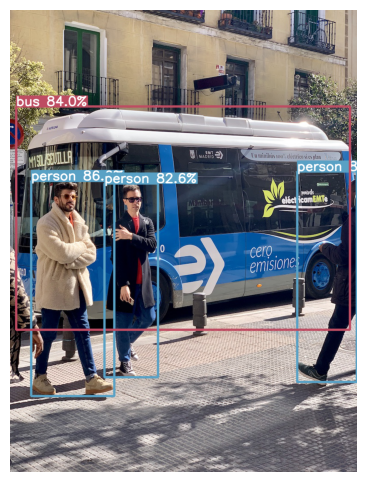


0: 480x640 9 persons, 1 bicycle, 1 umbrella, 1 bottle, 2 potted plants, 30.7ms
Speed: 2.2ms preprocess, 30.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


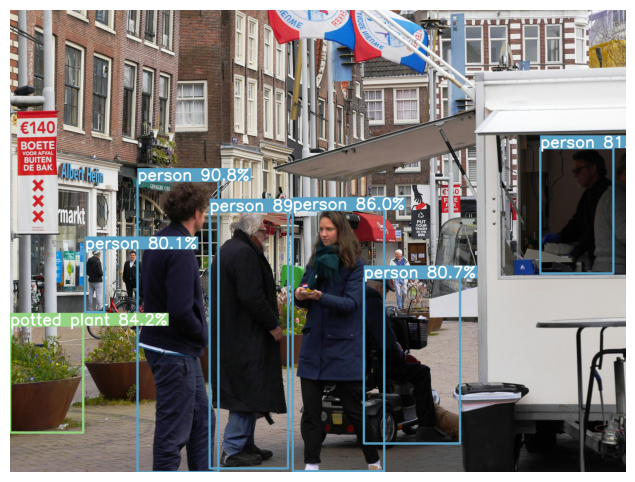

In [60]:
urls = ["https://ultralytics.com/images/bus.jpg",
       "https://images.unsplash.com/photo-1635341914750-7f38b76856d8?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1973&q=80",
       ]

# image = get_image(url[1])

# results = model.predict(image)
# print(results)

# plot_bboxes(image, results[0].boxes.data.numpy(), conf=0.8)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Process each image
for url in urls:
    # Get image
    image = get_image(url)

    # Perform prediction
    results = model(image)

    # Plot the image
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    
    plot_bboxes(image, results[0].boxes.data.numpy(), conf=0.8)

    plt.axis('off')
    plt.show()

In [61]:
# Use the model
# Check args.yaml for the list of hyperparameters
model.train(data="coco128.yaml", epochs=3)  # train the model
metrics = model.val()  # evaluate model performance on the validation set

Ultralytics YOLOv8.1.33 🚀 Python-3.9.18 torch-2.2.0 CPU (13th Gen Intel Core(TM) i9-13950HX)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=coco128.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

100%|██████████| 6.66M/6.66M [00:01<00:00, 5.86MB/s]
Unzipping /home/alberto/Documentos/GitHub/OR_FashionParsing/datasets/coco128.zip to /home/alberto/Documentos/GitHub/OR_FashionParsing/datasets/coco128...: 100%|██████████| 263/263 [00:00<00:00, 7666.87file/s]

Dataset download success ✅ (3.5s), saved to /home/alberto/Documentos/GitHub/OR_FashionParsing/datasets



100%|██████████| 755k/755k [00:00<00:00, 3.52MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

Model summary: 225 layers, 3157200 parameters, 3157184 gradients, 8.9 GFLOPs

Transferred 70/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'


train: Scanning /home/alberto/Documentos/GitHub/OR_FashionParsing/datasets/coco128/labels/train2017... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<00:00, 4274.38it/s]

train: New cache created: /home/alberto/Documentos/GitHub/OR_FashionParsing/datasets/coco128/labels/train2017.cache



val: Scanning /home/alberto/Documentos/GitHub/OR_FashionParsing/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G      2.974       4.81       2.56        278        640: 100%|██████████| 8/8 [00:18<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]

                   all        128        929     0.0289     0.0015     0.0003   0.000102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        2/3         0G      2.915      4.735      2.532        167        640: 100%|██████████| 8/8 [00:14<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]

                   all        128        929      0.029    0.00177   0.000317   0.000104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        3/3         0G      2.932      4.651      2.505        239        640: 100%|██████████| 8/8 [00:13<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]

                   all        128        929   3.81e-05    0.00571   0.000382   8.44e-05

3 epochs completed in 0.019 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.5MB


Optimizer stripped from runs/detect/train/weights/best.pt, 6.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.33 🚀 Python-3.9.18 torch-2.2.0 CPU (13th Gen Intel Core(TM) i9-13950HX)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


                   all        128        929      0.029    0.00177   0.000317   0.000104
                person        128        254     0.0571      0.126     0.0225    0.00736
               bicycle        128          6          0          0          0          0
                   car        128         46          0          0          0          0
            motorcycle        128          5          0          0          0          0
              airplane        128          6          0          0          0          0
                   bus        128          7          0          0          0          0
                 train        128          3          0          0          0          0
                 truck        128         12          0          0          0          0
                  boat        128          6          0          0          0          0
         traffic light        128         14          0          0          0          0
             stop sig

val: Scanning /home/alberto/Documentos/GitHub/OR_FashionParsing/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


                   all        128        929      0.029    0.00194   0.000327   0.000101
                person        128        254     0.0619      0.138     0.0232    0.00715
               bicycle        128          6          0          0          0          0
                   car        128         46          0          0          0          0
            motorcycle        128          5          0          0          0          0
              airplane        128          6          0          0          0          0
                   bus        128          7          0          0          0          0
                 train        128          3          0          0          0          0
                 truck        128         12          0          0          0          0
                  boat        128          6          0          0          0          0
         traffic light        128         14          0          0          0          0
             stop sig

## Instance Segmentation

In [64]:
dir(results[0].boxes)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'cls',
 'conf',
 'cpu',
 'cuda',
 'data',
 'id',
 'is_track',
 'numpy',
 'orig_shape',
 'shape',
 'to',
 'xywh',
 'xywhn',
 'xyxy',
 'xyxyn']

In [65]:
from ultralytics import YOLO

# Load a model
# "-seg" is added to the end of "yolov8X" for instance segmentation
model = YOLO("yolov8n-seg.yaml")  # build a new model from scratch
model = YOLO("yolov8n-seg.pt")  # load a pretrained model (recommended for training)

# Predict with the model
image = get_image("https://ultralytics.com/images/bus.jpg")
results = model.predict(image)  # predict on an image


0: 640x480 4 persons, 1 bus, 1 skateboard, 56.1ms
Speed: 2.7ms preprocess, 56.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


In [71]:
results[0].masks

ultralytics.engine.results.Masks object with attributes:

data: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0.,

In [9]:
def get_image_masks_centers_boxes(url, model):
    # Get image
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))

    # Perform prediction
    results = model(image)

    # Get the center of each mask
    masks = results[0].masks.data.numpy()
    centers = []

    for mask in masks:
        mask = cv2.resize(mask, (image.size[0], image.size[1]))
        mask = mask > 0.5
        mask = mask.astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            M = cv2.moments(contours[0])
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
            centers.append(center)
        else:
            centers.append(None)

    return np.array(image), masks, np.array(centers), results[0].boxes.data.numpy()

def plot_image_with_masks(image, masks, centers):
    # Plot the image
    plt.figure(figsize=(10, 6))
    plt.imshow(image)

    # Plot the masks
    for i, mask in enumerate(masks):
        mask = cv2.resize(mask, (image.size[0], image.size[1]))
        mask = mask > 0.5
        mask = mask.astype(np.uint8)
        contours, _ = cv2.findContours(np.array(mask), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            # cv2.drawContours(image, contours, -1, (255, 0, 0), 2)
            plt.scatter(centers[i][0], centers[i][1], c='r', s=100)

    # plt.axis('off')
    # plt.show()


In [7]:
len(boxes)

NameError: name 'boxes' is not defined

In [14]:
len(boxes)

6


0: 640x480 4 persons, 1 bus, 1 skateboard, 48.7ms
Speed: 1.9ms preprocess, 48.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


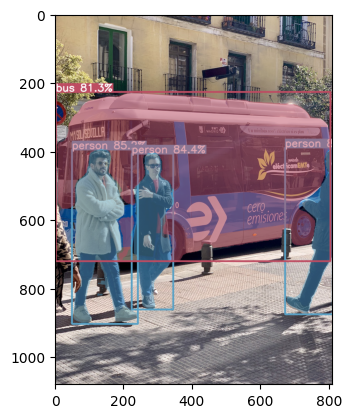

In [23]:
import matplotlib.pyplot as plt
urls = ["https://ultralytics.com/images/bus.jpg",
       "https://images.unsplash.com/photo-1635341914750-7f38b76856d8?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1973&q=80",
       ]

model = YOLO("yolov8n-seg.yaml")  # build a new model from scratch
model = YOLO("yolov8n-seg.pt")  # load a pretrained model (recommended for training)

image, masks, centers, boxes = get_image_masks_centers_boxes(urls[0], model=model)
# fig, ax = plt.subplots(1, 3, figsize=(15, 6))
# ax[0].imshow(cv2.resize(np.max(masks, axis=0), (image.shape[1], image.shape[0])))
# ax[0].plot(centers[:, 0], centers[:, 1], 'ro')
# ax[1].imshow(image)
masks = cv2.resize(masks.transpose((1,2,0)), (image.shape[1],image.shape[0])).transpose((2,0,1))
plot_bboxes(image, boxes, masks=masks[..., np.newaxis], conf=0.8)
plt.show()


0: 640x480 4 persons, 1 bus, 1 skateboard, 36.9ms
Speed: 1.4ms preprocess, 36.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 4 persons, 1 bus, 1 skateboard, 83.8ms
Speed: 2.7ms preprocess, 83.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


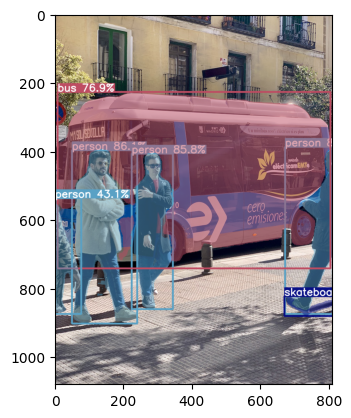


0: 480x640 10 persons, 1 umbrella, 2 potted plants, 42.7ms
Speed: 2.7ms preprocess, 42.7ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 bicycle, 1 umbrella, 2 potted plants, 43.3ms
Speed: 2.6ms preprocess, 43.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


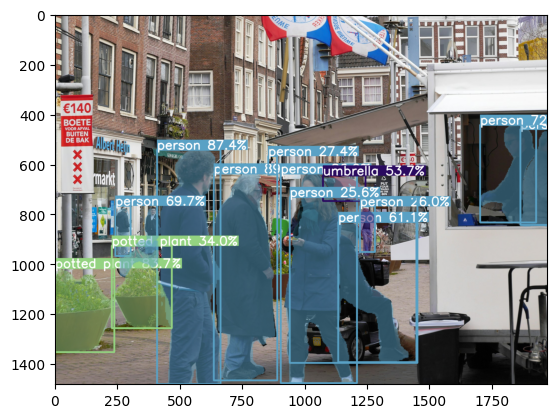

In [110]:
from ultralytics import YOLO

# Load a model
# "-seg" is added to the end of "yolov8X" for instance segmentation
model = YOLO("yolov8n-seg.yaml")  # build a new model from scratch
model = YOLO("yolov8n-seg.pt")  # load a pretrained model (recommended for training)

for url in urls:
    # Predict with the model
    image = get_image(url)
    results = model.predict(image)  # predict on an image
    boxes = results[0].boxes.data.numpy()
                    # results[0].masks.data.numpy()]
    # masks = cv2.resize(masks.transpose((1,2,0)), (image.shape[1],image.shape[0])).transpose((2,0,1))
    #print(results)
    _, masks, centers = get_centers_and_masks(url)
    masks = cv2.resize(masks.transpose((1,2,0)), (image.shape[1],image.shape[0])).transpose((2,0,1))

    plot_bboxes(image, boxes, masks[:,:,:,np.newaxis])
    # plot_image_with_masks(image, masks, centers)
    plt.show()

In [79]:
# Train the model
model.train(data="coco128-seg.yaml", epochs=5, imgsz=640)

# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95(B)
metrics.box.map50  # map50(B)
metrics.box.map75  # map75(B)
metrics.box.maps   # a list contains map50-95(B) of each category
metrics.seg.map    # map50-95(M)
metrics.seg.map50  # map50(M)
metrics.seg.map75  # map75(M)
metrics.seg.maps   # a list contains map50-95(M) of each category

# Export the model
# There are many different formats (pytorch=default, tensorflow, onnx, etc)
model.export()

Ultralytics YOLOv8.1.33 🚀 Python-3.9.18 torch-2.2.0 CPU (13th Gen Intel Core(TM) i9-13950HX)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=coco128-seg.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_

100%|██████████| 6.79M/6.79M [00:01<00:00, 5.72MB/s]
Unzipping /home/alberto/Documentos/GitHub/OR_FashionParsing/datasets/coco128-seg.zip to /home/alberto/Documentos/GitHub/OR_FashionParsing/datasets/coco128-seg...: 100%|██████████| 263/263 [00:00<00:00, 6320.74file/s]

Dataset download success ✅ (3.6s), saved to /home/alberto/Documentos/GitHub/OR_FashionParsing/datasets


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, 

YOLOv8n-seg summary: 261 layers, 3409968 parameters, 3409952 gradients, 12.8 GFLOPs

Transferred 87/417 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'


train: Scanning /home/alberto/Documentos/GitHub/OR_FashionParsing/datasets/coco128-seg/labels/train2017... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<00:00, 1839.29it/s]

train: New cache created: /home/alberto/Documentos/GitHub/OR_FashionParsing/datasets/coco128-seg/labels/train2017.cache



val: Scanning /home/alberto/Documentos/GitHub/OR_FashionParsing/datasets/coco128-seg/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]

Plotting labels to runs/segment/train/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      3.045      5.212      4.815      2.691        281        640: 100%|██████████| 8/8 [00:21<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.61s/it]

                   all        128        929      0.129   5.55e-05   0.000141   2.91e-05   4.87e-06   0.000721   6.19e-06   8.84e-07

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



        2/5         0G      2.942      5.164      4.716       2.65        173        640: 100%|██████████| 8/8 [00:22<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.56s/it]

                   all        128        929   3.73e-05    0.00549   0.000326   8.31e-05   1.06e-05    0.00155   4.93e-05   8.01e-06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G       2.97      5.102      4.702       2.63        244        640: 100%|██████████| 8/8 [00:22<00:00,  2.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]

                   all        128        929   6.15e-05    0.00746   0.000709   0.000221   1.53e-05    0.00222   0.000162   2.63e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      2.954      5.222       4.75      2.589        238        640: 100%|██████████| 8/8 [00:21<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]

                   all        128        929   5.97e-05    0.00768   0.000736   0.000258    0.00706    0.00741    0.00726   0.000761



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      2.937      5.042      4.719      2.609        231        640: 100%|██████████| 8/8 [00:22<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.80s/it]

                   all        128        929   7.13e-05     0.0091   0.000952    0.00032     0.0141    0.00808    0.00965      0.001



5 epochs completed in 0.045 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 7.1MB
Optimizer stripped from runs/segment/train/weights/best.pt, 7.1MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.1.33 🚀 Python-3.9.18 torch-2.2.0 CPU (13th Gen Intel Core(TM) i9-13950HX)
YOLOv8n-seg summary (fused): 195 layers, 3404320 parameters, 0 gradients, 12.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.23s/it]


                   all        128        929   7.14e-05     0.0091   0.000952    0.00032     0.0141    0.00802    0.00965      0.001
                person        128        254    0.00341      0.492     0.0664     0.0226    0.00164      0.236     0.0185    0.00446
               bicycle        128          6          0          0          0          0          0          0          0          0
                   car        128         46          0          0          0          0          0          0          0          0
            motorcycle        128          5          0          0          0          0          0          0          0          0
              airplane        128          6          0          0          0          0          0          0          0          0
                   bus        128          7          0          0          0          0          0          0          0          0
                 train        128          3          0          0   

val: Scanning /home/alberto/Documentos/GitHub/OR_FashionParsing/datasets/coco128-seg/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


                   all        128        929      6e-05    0.00807    0.00101   0.000344     0.0141    0.00819    0.00981    0.00196
                person        128        254    0.00345      0.496     0.0709     0.0243    0.00173      0.248     0.0299    0.00597
               bicycle        128          6          0          0          0          0          0          0          0          0
                   car        128         46          0          0          0          0          0          0          0          0
            motorcycle        128          5          0          0          0          0          0          0          0          0
              airplane        128          6          0          0          0          0          0          0          0          0
                   bus        128          7          0          0          0          0          0          0          0          0
                 train        128          3          0          0   

'runs/segment/train/weights/best.torchscript'

In [87]:
M

{'m00': 12208.5,
 'm10': 311627.6666666666,
 'm01': 8896758.5,
 'm20': 12683668.583333332,
 'm11': 230145214.29166666,
 'm02': 6548170486.083333,
 'm30': 633343059.6,
 'm21': 9465550807.4,
 'm12': 170949661959.2,
 'm03': 4865604480221.95,
 'mu20': 4729226.790147348,
 'mu11': 3051296.75455454,
 'mu02': 64793182.78462696,
 'mu30': 68155045.92922258,
 'mu21': 66748886.13099909,
 'mu12': -642621301.470243,
 'mu03': -709156250.4580078,
 'nu20': 0.03172966786189391,
 'nu11': 0.020471979219054085,
 'nu02': 0.43471507303356477,
 'nu30': 0.004138493200165876,
 'nu21': 0.004053108725928446,
 'nu12': -0.03902108567541951,
 'nu03': -0.043061203765064664}


0: 480x640 10 persons, 1 umbrella, 2 potted plants, 35.9ms
Speed: 2.7ms preprocess, 35.9ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


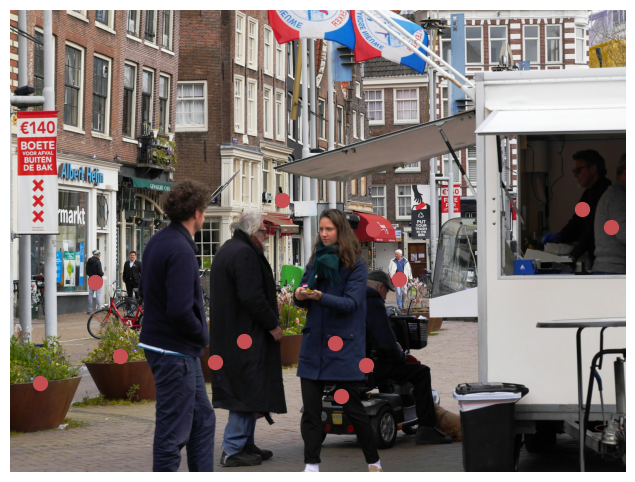

In [88]:
# Get the center of each mask
image = get_image(urls[1])
results = model.predict(image)
masks = results[0].masks.data.numpy()
centers = []

for mask in masks:
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
    mask = mask > 0.5
    mask = mask.astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        M = cv2.moments(contours[0])
        center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
        centers.append(center)
    else:
        centers.append(None)

# Plot the image
plt.figure(figsize=(10, 6))
plt.imshow(image)

# Plot the masks
for i, mask in enumerate(masks):
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
    mask = mask > 0.5
    mask = mask.astype(np.uint8)
    contours, _ = cv2.findContours(np.array(mask), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        # cv2.drawContours(image, contours, -1, (255, 0, 0), 2)
        plt.scatter(centers[i][0], centers[i][1], c='r', s=100)

plt.axis('off')
plt.show()
